# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re

import project_tests as t

from collections import defaultdict

from nltk import word_tokenize, download as nltk_download
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

nltk_download('punkt')
nltk_download('stopwords')
nltk_download('wordnet')

[nltk_data] Downloading package punkt to /home/brendalf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/brendalf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brendalf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('../data/user-item-interactions.csv')
df_content = pd.read_csv('../data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [3]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
# group by user and count interactions
user_interactions = df.groupby(['email']).size().reset_index(name='interactions')

In [6]:
# order by number of interactions
user_interactions = user_interactions.sort_values('interactions', ascending=False)
user_interactions.head()

,email,interactions
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160


In [7]:
stats = user_interactions.describe()
stats

,interactions
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


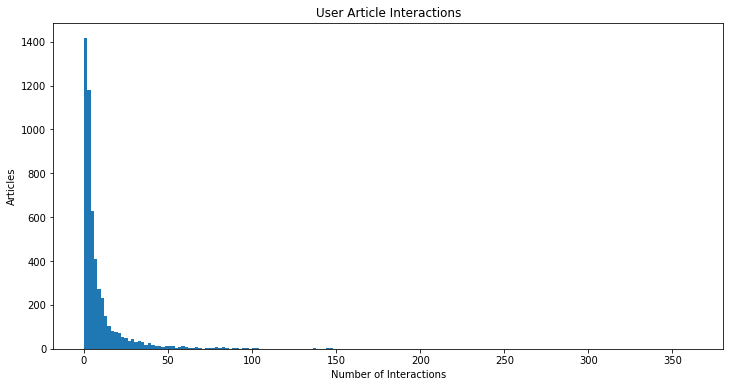

In [8]:
plt.figure(figsize=[12, 6])

bins = np.arange(0, user_interactions.interactions.max(), 2)
plt.hist(data=user_interactions, x='interactions', bins=bins)

plt.xlabel("Number of Interactions")
plt.ylabel("Articles")
plt.title("User Article Interactions");

In [9]:
# Fill in the median and maximum number of user_article interactios below
median_val = stats.loc['50%'][0]
max_views_by_user = stats.loc['max'][0]

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Shape before droping duplicated lines
df_content.shape

(1056, 5)

In [11]:
# number of duplicated articles ids
df_content.duplicated(['article_id']).sum()

5

In [12]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(['article_id'], inplace=True)

In [13]:
# shape after droping duplicated lines
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [14]:
# a. The number of unique articles that have an interaction with a user.
len(df.article_id.unique())

714

In [15]:
# b. The number of unique articles in the dataset (whether they have any interactions or not).
len(df_content.article_id.unique())

1051

In [16]:
# c. The number of unique users in the dataset. (excluding null values
unique_users = df.email.dropna().unique()
len(unique_users)

5148

In [17]:
# d. The number of user-article interactions in the dataset.
df.shape[0]

45993

In [18]:
unique_articles = len(df.article_id.unique())
total_articles = len(df_content.article_id.unique())
unique_users = len(unique_users)
user_article_interactions = df.shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [19]:
articles_seen = df.groupby('article_id').size().reset_index(name='views')

In [20]:
articles_seen = articles_seen.sort_values('views', ascending=False)
articles_seen.head()

,article_id,views
699,1429.0,937
625,1330.0,927
701,1431.0,671
697,1427.0,643
652,1364.0,627


In [21]:
most_viewed_article_id = '1429.0'
max_views = 937

In [22]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [23]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [24]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''    
    top_articles = df.groupby(['article_id', 'title']).size().reset_index(name='count')
    return list(top_articles.sort_values('count', ascending=False)[:n].title)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby(['article_id']).size().reset_index(name='count')
    return list(top_articles.sort_values('count', ascending=False)[:n].article_id.astype(str))

In [25]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [26]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [27]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Drop duplicated rows and create rows and columns
    user_item = df.drop_duplicates().groupby(['user_id', 'article_id']).size().unstack()
    
    # Fill nan with 0
    user_item = user_item.fillna(0)
    
    # Convert float to int
    user_item = user_item.astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [28]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [29]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    dot_product = user_item.loc[user_id, :].dot(user_item.T)
    
    # sort by similarity
    dot_product.sort_values(ascending=False, inplace=True)
    
    # create list of just the ids
    most_similar_users = dot_product.index.tolist()

    # remove the own user's id
    most_similar_users.remove(user_id)   
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [30]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [31]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    return df[df.article_id.isin(article_ids)].title.drop_duplicates().values.tolist()


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    articles_ids = user_item.loc[user_id, user_item.loc[user_id] == 1].index.astype(str).tolist()
    
    return articles_ids, get_article_names(articles_ids) # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    articles_seen = set(get_user_articles(user_id)[0])
    neighbors = find_similar_users(user_id)
    
    recs = []
    for n in neighbors:
        articles = set(get_user_articles(n)[0])
        # new_recs = np.setdiff1d(articles, articles_seen, assume_unique=True)
        # recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        recs += list(articles - articles_seen)
        if len(recs) >= m:
            break
    
    return recs[:m] # return your recommendations for this user_id    

In [32]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['simple graphing with ipython and\xa0pandas',
 'analyze accident reports on amazon emr spark',
 'modeling energy usage in new york city',
 'brunel in jupyter',
 'challenges in deep learning',
 'i am not a data scientist – ibm watson data lab',
 'ml algorithm != learning machine',
 'flightpredict ii: the sequel  – ibm watson data lab',
 'machine learning for the enterprise',
 '54174    detect potentially malfunctioning sensors in r...\nName: title, dtype: object']

In [33]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [34]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    articles = user_item.loc[user_id]
    
    neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity', 'num_interactions'])
    for user in user_item.index:
        similarity = user_item.loc[user_id, :].dot(user_item.loc[user].T)
        num_interactions = user_item.loc[user].values.sum()
        neighbors_df.loc[user] = [user, similarity, num_interactions]
    
    # sort by similarity
    neighbors_df = neighbors_df.astype(int)
    neighbors_df.sort_values(["similarity", "num_interactions"], ascending=[False, False], inplace=True)

    # remove the own user's id
    neighbors_df.drop(user_id, inplace=True)  
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    articles_seen, _ = get_user_articles(user_id)
    neighbors = get_top_sorted_users(user_id)
    
    recs = np.array([])
    for n in neighbors.index:
        articles, _ = get_user_articles(n)
        new_recs = np.setdiff1d(articles, articles_seen, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        if len(recs) >= m:
            break
    
    recs = df[df.article_id.isin(recs[:m])][['article_id', 'user_id']].groupby('article_id').count().sort_values('user_id', ascending=False).index.tolist()
    
    return recs, get_article_names(recs)

In [35]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1162.0, 1172.0, 1164.0, 109.0, 12.0, 1186.0, 1014.0, 111.0, 1059.0, 1157.0]

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'analyze energy consumption in buildings', 'analyze open data sets with pandas dataframes', 'apache spark lab, part 3: machine learning', 'airbnb data for analytics: washington d.c. listings', 'airbnb data for analytics: amsterdam calendar', 'tidy up your jupyter notebooks with scripts', 'tensorflow quick tips', '1448    i ranked every intro to data science course on...\nName: title, dtype: object', 'connect to db2 warehouse on cloud and db2 using scala']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [36]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).index.tolist()[0]
user131_10th_sim = get_top_sorted_users(131).index.tolist()[10]

In [37]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**ANSWER**  
Since that the new user didn't interact with any article yet, we can recommend the most seen articles with the `get_top_article_ids`. A better way would be use a content based recommendation approach to recommend, for example, most seen articles by users with the same age that the new user.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [38]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [39]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [40]:
# find nans
df_content.isna().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [41]:
# fill nans
df_content.fillna("", inplace=True)

In [42]:
df_content['doc_name_with_description'] = df_content['doc_full_name'] + " " + df_content['doc_description']

In [43]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,doc_name_with_description
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,Detect Malfunctioning IoT Sensors with Streami...
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,Communicating data science: A guide to present...
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,"This Week in Data Science (April 18, 2017) Her..."
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,DataLayer Conference: Boost the performance of...
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,Analyze NY Restaurant data using Spark in DSX ...


In [44]:
def tokenize(text):
    """
    Tokenize a text string by converting to lower, removing ponctuation, 
    spliting in wordss and applying a Lemmatizer and Stemmer.
    
    Args:
        text: raw text string.
    Returns:
        words: list of lemmatize and stemed words.
    """
    # normalize the text removing ponctuation and making it lowercase
    normalized = re.sub("[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize the normalized text
    words = word_tokenize(normalized)
    
    # remove stop words
    words = [w for w in words if w not in stopwords.words("english")]
    
    # lemmetatization
    wordnet = WordNetLemmatizer()
    words = [wordnet.lemmatize(w) for w in words]
    
    # stemming
    porter = PorterStemmer()
    words = [porter.stem(w) for w in words]
    
    return np.unique(words)

In [45]:
# droping unused columns
df_content.drop(columns=['doc_body', 'doc_description', 'doc_full_name', 'doc_status'], inplace=True)

In [46]:
# tokenize words
i = 1
for idx in df_content.index:
    words = tokenize(df_content.loc[idx, 'doc_name_with_description'])
    for w in words:
        df_content.loc[idx, w] = 1

In [47]:
# drop doc_name_with_description
df_content.drop('doc_name_with_description', axis=1, inplace=True)

In [48]:
df_content.fillna(0, inplace=True)

In [49]:
df_content.head()

,article_id,analyt,bad,detect,iot,malfunct,python,read,real,sensor,...,comparison,contrari,discrimin,distinct,held,regim,typifi,hould,jean,nichola
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
dot_prod_articles = df_content.set_index('article_id')
dot_prod_articles = dot_prod_articles.dot(dot_prod_articles.T)
dot_prod_articles.head()

article_id,0,1,2,3,4,5,6,7,8,9,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050
article_id,,,,,,,,,,,,,,,,,,,,,
0,12.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
1,0.0,22.0,2.0,3.0,1.0,1.0,2.0,3.0,6.0,3.0,...,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,0.0
2,0.0,2.0,8.0,1.0,1.0,1.0,0.0,1.0,3.0,2.0,...,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,3.0,1.0,20.0,1.0,1.0,1.0,1.0,2.0,2.0,...,2.0,1.0,2.0,1.0,0.0,0.0,4.0,1.0,2.0,0.0
4,1.0,1.0,1.0,1.0,19.0,2.0,0.0,2.0,2.0,3.0,...,2.0,5.0,2.0,1.0,0.0,0.0,0.0,1.0,5.0,1.0


In [51]:
def find_similar_articles(article_id, threshold=15):
    '''
    INPUT
    article_id - a article identifier (int)
    threshold - threshold to whether a article is simmilar or not
    OUTPUT
    similar_articles - an array of the most similar articles id
    '''
    #try:
    # find the most similar articles indices
    similar_articles = dot_prod_articles.loc[article_id, np.where(dot_prod_articles.loc[article_id] >= np.max(dot_prod_articles[article_id]) - threshold)]

    return similar_articles.sort_values(ascending=False).index.tolist()
    # except:
    #    return np.array([])

In [52]:
def make_content_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the similiar articles that the user has seen
    Does this until m recommendations are found   
    '''
    # Create dictionary to return with users and ratings
    recs = np.array([])    
        
    # Pull only the articles the user has seen
    try:
        articles, _ = get_user_articles(user_id)

        articles = [int(float(x)) for x in articles]

        for article in articles:
            articles_relac = find_similar_articles(article)
            new_recs = np.setdiff1d(articles_relac, articles, assume_unique=True)
            recs = np.unique(np.concatenate([new_recs, recs], axis=0))

            if len(recs) >= 10:
                break
    except:
        # new user
        return get_article_names(get_top_article_ids(10))
    
    return get_article_names(recs[:m])

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**ANSWER**  
The content based recommendation system implemented above create a one hot encode from words in the article name and description. With the matrix created, we can make a dot product to find similar articles (articles that uses the same words). I didnt use a CountVectorizer or a Tfidf because the dot product use to find similar articles.   
The recommendation system also recommends the top articles for new users.  

**Improvements**:
1. Use the doc_body to get more words and knowledge about the article.
2. Group different words that has the same meaning.
3. Insert in the df_content missing articles like 1427.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [53]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
user_item.loc[user_item.sum(axis=1) == 1][user_item[1427] == 1]

/home/brendalf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2820,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# make recommendations for a brand new user
make_content_recs(0)

# make a recommendations for a user who only has interacted with article id '1427.0'
make_content_recs(331)

['healthcare python streaming application demo',
 'use deep learning for image classification',
 'apache spark lab, part 1: basic concepts',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'finding optimal locations of new store using decision optimization']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [56]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [57]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [58]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item)

**ANSWER**  
The user-item matrix in the lesson contains the ratings and null values, but here in this project we only obtain whether the user has viewed an article or not.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

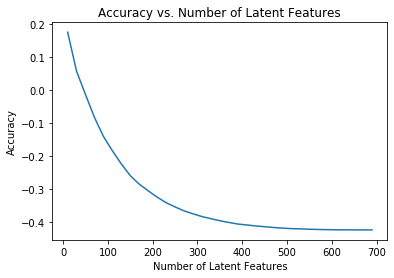

In [59]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [60]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(user_item_test.index.values)
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [61]:
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [62]:
# find the common users in both test and train set
user_item_train.index.isin(test_idx).sum()

20

In [63]:
# total number of user in test set
len(test_idx)

682

In [64]:
# find the common articles in both test and train set
user_item_train.columns.isin(test_arts).sum()

574

In [65]:
user_item_test = user_item_test.loc[user_item_matrix.loc[user_item_train.index.isin(test_idx), :].index]

In [66]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


**ERROR REPORT**  
There is a error in this validation. The `sol_4_test` is asking for movies instead of articles.

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [67]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [68]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

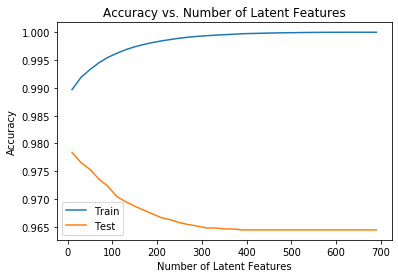

In [69]:
k_latent_features = np.arange(10,700+10,20)
error_training = []
error_testing = []

for k in k_latent_features:
    # subset with k latent features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_k, vt_test_k = u_test[:, :k], vt_test[:k, :]
    
    # dot product
    train_preds = np.around(np.dot(np.dot(u_train_k, s_train_k), vt_train_k))
    test_preds = np.around(np.dot(np.dot(u_test_k, s_train_k), vt_test_k))
    
    # calculate the error of each prediction with the true value
    train_error = np.subtract(user_item_train, train_preds)
    test_error = np.subtract(user_item_test, test_preds)
    
    train_error = np.sum(np.sum(np.abs(train_error)))
    test_error = np.sum(np.sum(np.abs(test_error)))
    
    # saving error for k latent features
    error_training.append(train_error)
    error_testing.append(test_error)
    
    
plt.plot(k_latent_features, 1 - np.array(error_training) / (user_item_train.shape[0] * user_item_test.shape[1]), label='Train');
plt.plot(k_latent_features, 1 - np.array(error_testing) / (user_item_test.shape[0] * user_item_test.shape[1]), label='Test');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**ANSWER**  
Increasing the latent features causes overfitting problem. Thus we can see from the above graph, the accuracy becomes worser when the number of latent features increases. Since the common users between the train and test set are too few, other recommendation methods may be used to improve our recommendation, like collaborative filtering or content based recommendation

We could use A/B testing to test how well our recommendation engine is working in practice to further engage users. We seperate two groups of user, one uses our recommendation engine and another uses random recommendation. we compare the hit rate of the recommendation articles to measure if our recommendation engine boost up the view count. If it is significant, we can conclude that our recommendation engine works well.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [70]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0